# Import libraries

In [1]:
import pathlib
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
# from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

# Read data from file

In [2]:
path = pathlib.Path('D:\DataScience\Real-Time-Data-Analysis\data\\raw\data.csv')

df = pd.read_csv(path,index_col='index',parse_dates=True)

# Looking into data

In [3]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,Date
index,,,,,,,
2022-12-07 11:15:00,18584.800781,18595.849609,18568.349609,18594.400391,18594.400391,0,NaN
2022-12-07 12:15:00,18594.000000,18607.000000,18569.400391,18597.099609,18597.099609,0,NaN
2022-12-07 13:15:00,18597.500000,18614.800781,18566.500000,18570.550781,18570.550781,0,NaN
2022-12-07 14:15:00,18570.900391,18618.949219,18550.400391,18553.599609,18553.599609,0,NaN
2022-12-07 15:15:00,18554.750000,18556.650391,18529.099609,18551.550781,18551.550781,0,NaN


In [4]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume,Date
count,3446.000000,3446.000000,3446.000000,3446.000000,3446.000000,3446.0,0.0
mean,16481.896683,16513.388822,16445.274962,16480.737474,16480.737474,0.0,NaN
std,1306.454482,1305.139024,1308.639347,1306.470302,1306.470302,0.0,NaN
min,13253.349609,13296.700195,13135.099609,13241.599609,13241.599609,0.0,NaN
25%,15594.149902,15632.637451,15567.662842,15592.425049,15592.425049,0.0,NaN
50%,16695.875000,16720.299805,16654.625000,16690.725586,16690.725586,0.0,NaN
75%,17548.149902,17583.225586,17515.712402,17548.100586,17548.100586,0.0,NaN
max,18871.949219,18886.699219,18832.449219,18844.150391,18844.150391,0.0,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3446 entries, 2020-12-09 09:15:00 to 2022-12-07 15:15:00
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3446 non-null   float64
 1   High       3446 non-null   float64
 2   Low        3446 non-null   float64
 3   Close      3446 non-null   float64
 4   Adj Close  3446 non-null   float64
 5   Volume     3446 non-null   int64  
 6   Date       0 non-null      float64
dtypes: float64(6), int64(1)
memory usage: 215.4 KB


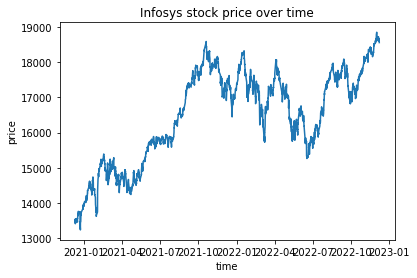

In [6]:
plt.plot(df.index, df["Close"])
plt.title("Infosys stock price over time")
plt.xlabel("time")
plt.ylabel("price")
plt.show()

# Find p, d, and q values for ARIMA model 

Before building the ARIMA model, let’s see if there is some cross-correlation in out data.

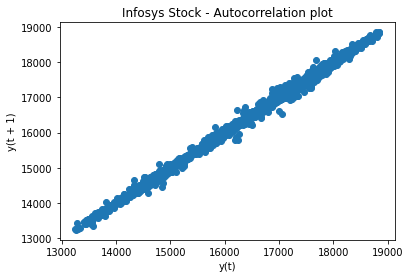

In [7]:
lag_plot(df['Close'], lag=1)
plt.title('Infosys Stock - Autocorrelation plot')
plt.show()

p is order of Autoregrassion <br>
d is order of differencing requiredd to make time series stationary <br>
q is order Moving aaverages

## Stationarity

Substract current value from previous value. We need to do diffenting peration multiple times to make series stationary. <br>
Select minimun value for ARIMA model.

### ADF test

We will use Augumented Dickey Fuller (ADF) test check stationarity in series. <br>
<br>
Null hypothesis of ADF test is that time series is non-stationary. If p-value of test is less than 0.05 then wee can reject null hypothesis. <br>
So, if p-value > 0.05 we'll find order of diffencing.  

In [8]:
from statsmodels.tsa.stattools import adfuller

In [9]:
dftest = adfuller(df['Close'],autolag='AIC')
print('1. ADF statistic :',dftest[0])
print('2. P-value :',dftest[1])

1. ADF statistic : -1.8976793796040619
2. P-value : 0.3331535901238367


## ## We find our series is non-stationary.

In [10]:
# from pmdarima import auto_arima
# import warnings
# warnings.filterwarnings('ignore')

## Autocorrelation Function (ACF) Plot

In [11]:
from statsmodels.graphics.tsaplots import plot_acf

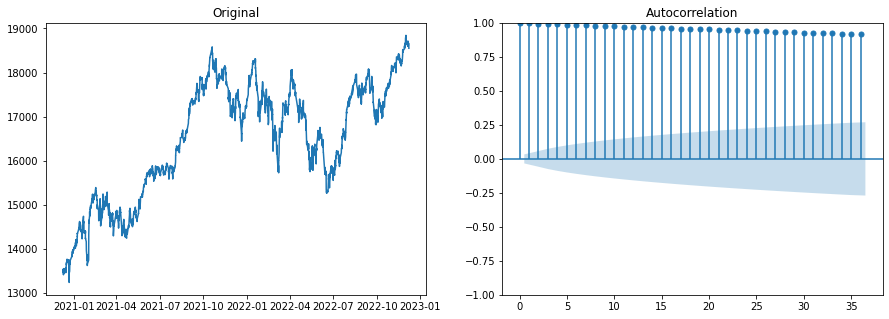

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(df['Close'])
ax1.set_title('Original')
plot_acf(df['Close'], ax=ax2);

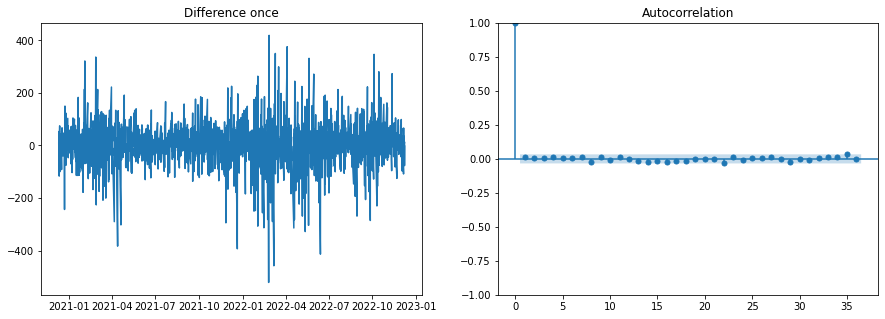

In [13]:
diff = df['Close'].diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(diff)
ax1.set_title('Difference once')
plot_acf(diff, ax=ax2);

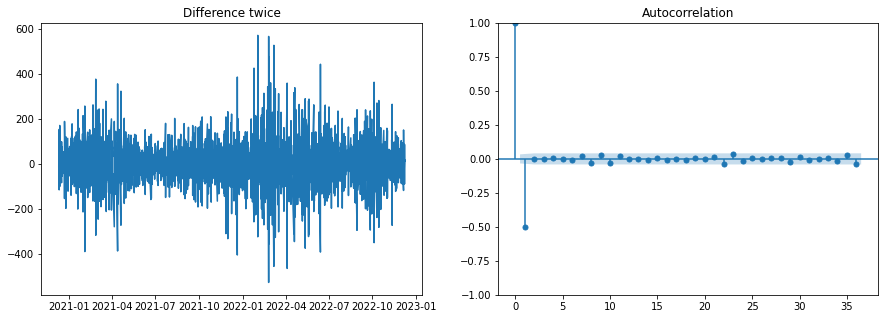

In [14]:
diff = df['Close'].diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(diff)
ax1.set_title('Difference twice')
plot_acf(diff, ax=ax2);

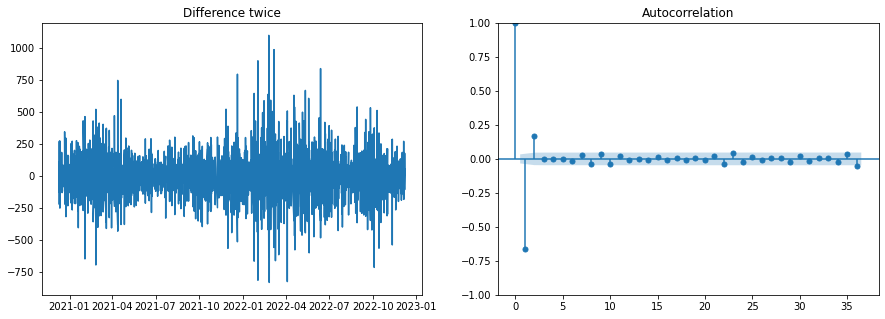

In [15]:
diff = df['Close'].diff().diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(diff)
ax1.set_title('Difference twice')
plot_acf(diff, ax=ax2);

## ## Here we find diffence order 3 is good.

Because there is gives positive value in third order differencing.

# p

p is the order of Auto regression (AR). It refers to number of lags to be used ass predictors. <br>
We can find required number of AR terms by inspecting Partial Autocorrelation (PACF) plot. <br>
The Partial Autocorrelation represents correlation between series and it's lags.

In [16]:
from statsmodels.graphics.tsaplots import plot_pacf

c:\Users\walde\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


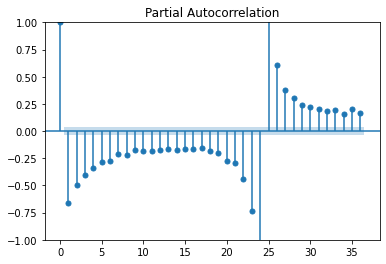

In [17]:
diff = df['Close'].diff().diff().diff().dropna()

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# ax1.plot(diff)
# ax1.set_title('Difference once')
p = plot_pacf(diff);

In [18]:
# statsmodels.tsa.stattools.pacf
from statsmodels.tsa.stattools import pacf
diff = df['Close'].diff().diff().diff().dropna()
print(pacf(diff))

[ 1.         -0.66573129 -0.49903226 -0.40251431 -0.33717465 -0.28207025
 -0.27308847 -0.21103036 -0.21591039 -0.17379562 -0.18239661 -0.18410452
 -0.17827857 -0.16370768 -0.1708103  -0.16037063 -0.16342285 -0.15914895
 -0.18218277 -0.2052621  -0.27419828 -0.29689365 -0.43984785 -0.73683346
 -2.76528279  1.55599812  0.60797626  0.37602217  0.30300747  0.24160987
  0.21770517  0.20418941  0.18289434  0.19558701  0.15464398  0.1989952 ]


In [19]:
from statsmodels.tsa.stattools import acf
diff = df['Close'].diff().diff().diff().dropna()
print(acf(diff))

[ 1.00000000e+00 -6.65537931e-01  1.65240021e-01 -1.08244949e-03
  2.19684727e-03  1.85445009e-03 -1.28044635e-02  2.90246193e-02
 -3.96685013e-02  3.92297710e-02 -3.48332173e-02  2.39113537e-02
 -6.35293684e-03 -1.25995733e-04 -6.03941256e-03  1.08445678e-02
 -9.59144033e-03  5.99585565e-03 -7.00217199e-03  8.68813773e-03
 -1.02203972e-02  2.40849350e-02 -4.11171767e-02  3.99893496e-02
 -2.47501603e-02  1.16152268e-02 -8.21459703e-03  6.44889382e-03
  8.00984423e-03 -2.36947870e-02  2.32891182e-02 -1.38105875e-02
  3.34128692e-03  7.16625460e-03 -2.06331254e-02  3.79928266e-02]


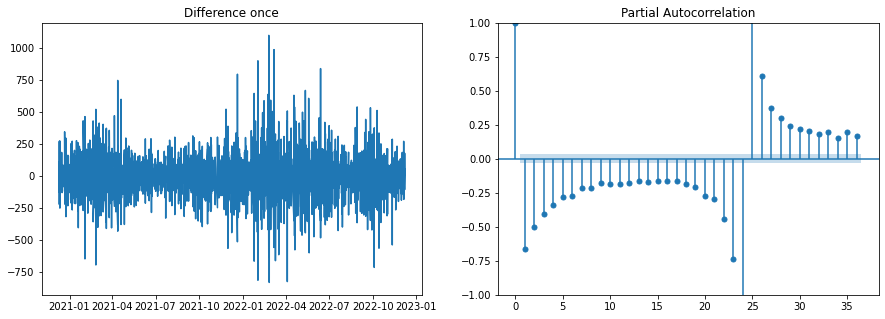

In [20]:
diff = df['Close'].diff().diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(diff)
ax1.set_title('Difference once')
plot_pacf(diff, ax=ax2);

## ## 20 is the positive value for Auto regression

# q

q is the order of moving average (MA). It refers to number of laged forecast erros that should be go into the ARIMA. <br>
We can look at ACF plot for number of MA term.

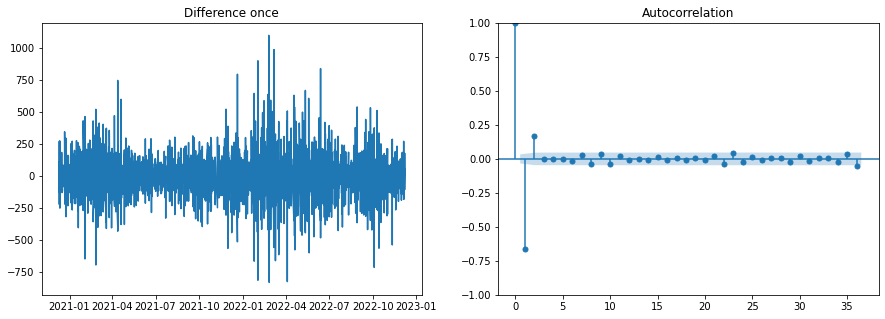

In [21]:
diff = df['Close'].diff().diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(diff)
ax1.set_title('Difference once')
plot_acf(diff, ax=ax2);

## ## We find that 2 is no order for MA

In [22]:
# stepswise_fit = auto_arima(df['Close'], trace=True, suppress_warnings=True)
# stepswise_fit.summary()

# Let's build model

In [23]:
# train_data, test_data = df[0:int(len(df)*0.9)], df[int(len(df)*0.9):]

# training_data = train_data['Close'].values
# test_data = test_data['Close'].values

# history = [x for x in training_data]
# model_predictions = []
# N_test_observations = len(test_data)

# residuals = 0

# for time_point in range(N_test_observations):
#     model = ARIMA(history, order=(20,3,2))
#     model_fit = model.fit()
#     output = model_fit.forecast()
#     yhat = output[0]
#     model_predictions.append(yhat)
#     true_test_value = test_data[time_point]
#     history.append(true_test_value)

#     residuals = pd.DataFrame(model_fit.resid)
    
# MSE_error = mean_squared_error(test_data, model_predictions)
# print('Testing Mean Squared Error is {}'.format(MSE_error))

In [24]:
# residuals = residuals[1:]

In [25]:
# fig, ax = plt.subplots(1,2)
# residuals.plot(title="Residuals", ax=ax[0])
# residuals.plot(kind='kde', title='Density', ax=ax[1])
# plt.show()

In [26]:
# test_set_range = df[int(len(df)*0.7):]
# plt.plot(test_set_range.index, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
# plt.plot(test_set_range.index, test_data, color='red', label='Actual Price')
# plt.title('Infosys Prices Prediction')
# plt.xlabel('Date')
# plt.ylabel('Prices')
# plt.legend()
# plt.show()

In [27]:
df.tail(10)

,Open,High,Low,Close,Adj Close,Volume,Date
index,,,,,,,
2022-12-06 13:15:00,18614.949219,18641.099609,18596.500000,18616.750000,18616.750000,0,NaN
2022-12-06 14:15:00,18616.650391,18654.199219,18601.599609,18651.550781,18651.550781,0,NaN
2022-12-06 15:15:00,18651.449219,18652.400391,18633.599609,18647.800781,18647.800781,0,NaN
2022-12-07 09:15:00,18638.849609,18665.699219,18609.000000,18661.699219,18661.699219,0,NaN
2022-12-07 10:15:00,18662.750000,18668.050781,18565.000000,18585.150391,18585.150391,0,NaN
2022-12-07 11:15:00,18584.800781,18595.849609,18568.349609,18594.400391,18594.400391,0,NaN
2022-12-07 12:15:00,18594.000000,18607.000000,18569.400391,18597.099609,18597.099609,0,NaN
2022-12-07 13:15:00,18597.500000,18614.800781,18566.500000,18570.550781,18570.550781,0,NaN
2022-12-07 14:15:00,18570.900391,18618.949219,18550.400391,18553.599609,18553.599609,0,NaN


In [28]:
history = [x for x in df['Close'].values]

modelF = ARIMA(history, order=(25,3,2))
model_Fit = modelF.fit()

c:\Users\walde\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\walde\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [35]:
future_index = pd.date_range(start='2022-11-18 09:30:00', end='2022-11-18 22:30:00', freq='1H')

In [36]:
future_index[:10]

DatetimeIndex(['2022-11-18 09:30:00', '2022-11-18 10:30:00',
               '2022-11-18 11:30:00', '2022-11-18 12:30:00',
               '2022-11-18 13:30:00', '2022-11-18 14:30:00',
               '2022-11-18 15:30:00', '2022-11-18 16:30:00',
               '2022-11-18 17:30:00', '2022-11-18 18:30:00'],
              dtype='datetime64[ns]', freq='H')

In [37]:
print(len(future_index))

14


In [39]:
output = model_Fit.forecast(steps=14)

In [40]:
output

array([18548.38129768, 18545.52140925, 18539.79169983, 18534.19692245,
       18526.79226273, 18522.91250468, 18514.63772336, 18509.76273864,
       18503.76684435, 18497.7934455 , 18490.34258927, 18482.32023251,
       18477.15572152, 18470.74366914])

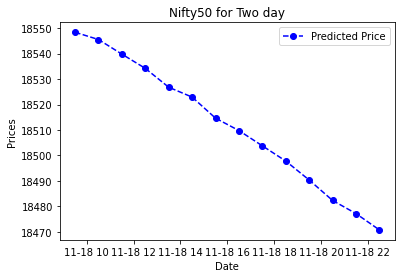

In [41]:
plt.plot(future_index, output, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.title('Nifty50 for Two day')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()

1,2,1 and 0,1,0